In [335]:
# check the kernel running in the notebook
# !uname -a
# find the variables in the notebook
%whos

Variable                 Type                   Data/Info
---------------------------------------------------------
A_TCR_seq                ndarray                37476: 37476 elems, type `object`, 299808 bytes (292.78125 kb)
A_TCR_seq_encode         Tensor                 tensor([[-1.3430,  0.4650<...>     dtype=torch.float64)
DataLoader               type                   <class 'torch.utils.data.dataloader.DataLoader'>
Dataset                  type                   <class 'torch.utils.data.dataset.Dataset'>
F                        module                 <module 'torch.nn.functio<...>/torch/nn/functional.py'>
HLAencoder               OneHotEncoder          OneHotEncoder()
KFold                    ABCMeta                <class 'sklearn.model_selection._split.KFold'>
LabelEncoder             type                   <class 'sklearn.preproces<...>ing._label.LabelEncoder'>
OneHotEncoder            type                   <class 'sklearn.preproces<...>_encoders.OneHotEncoder'>
RepeatedKF

In [353]:
import random
import tqdm
import logging
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, RepeatedKFold, KFold, StratifiedKFold
# from imblearn.under_sampling import RandomUnderSampler

In [354]:
def encode_seqCDR(seqCDR):
    encoding_list = []
    for i in range(len(seqCDR)):
        if seqCDR[i] == "*":
            encoding_list.append(np.zeros(5).reshape(1,5))
        elif seqCDR[i] == "_":
            # print("Error: seqCDR contains '_'")
            # encoding_list.append(np.zeros(5).reshape(1,5))
            return np.nan
        else:
            encoding_list.append(af.loc[seqCDR[i]].values.reshape(1,5))
    return np.array(encoding_list).reshape(1,-1)

af = pd.read_csv("~/data/project/pMHC-TCR/library/Atchley_factors.csv")
af.index = af["Amino acid"]
af.drop(columns=["Amino acid"], inplace=True)

In [355]:
class TCR_encode_data(Dataset):
    def __init__(self, file_path):
        df = pd.read_csv(file_path, index_col=0)
        df["Neo_first3"] = df["NeoAA"].str[:3]
        df["Neo_last3"] = df["NeoAA"].str[-3:]
        df = df.drop(columns=["NeoAA"])

        # encode the Neo_first3, Neo_last3
        for seq in ["Neo_first3", "Neo_last3"]:
            df[seq] = df[seq].apply(lambda x: encode_seqCDR(x))

        # drop the rows with duplicate CDR3 sequences
        df = df.drop_duplicates(subset=["AseqCDR3", "BseqCDR3"], keep="first")
        
        # drop the rows with length == max length, which is much longer than the others
        df = df.loc[df["AseqCDR3"].str.len() < 50, :]

        # encode the CDR3 region
        len_map = {
            "AseqCDR3": df["AseqCDR3"].apply(lambda x: len(x)).max(),
            "BseqCDR3": df["BseqCDR3"].apply(lambda x: len(x)).max(),
        }
        print(len_map)
        for chain in ["AseqCDR3", "BseqCDR3"]:
            length = len_map[chain]
            df[chain] = df[chain].apply(
                lambda x: x + "*" * (length - len(x)))
            df[chain] = df[chain].apply(lambda x: encode_seqCDR(x))
        
        # If there is any NaN value, drop the row
        df = df.dropna()
        print(df.shape)

        # concatenate the encoded features
        X_features = torch.zeros((len(df),0))
        for seq in ["AseqCDR3", "BseqCDR3"]:
            X_features = torch.cat((X_features, 
            torch.from_numpy(np.vstack(df[seq].values))), dim=1)

        y = df["Class"].apply(lambda x: 1 if x == "positive" else 0).values
        
        # discard the duplicate rows, keep the first one
        self.X_features = X_features
        self.y = torch.from_numpy(y).float()
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X_features[idx], self.y[idx]

In [356]:
class TCR_autoencoder(nn.Module):
    '''
    The autoencoder for TCR sequence.
    For 230221 dataset, the sequnce length is 41 (20+21), and the input size is 41*5,
    the hidden size is 10. And the output size is 41*5. We apply convolutional neural
    network to encode the sequence, and apply deconvolutional neural network to decode
    the sequence. The activation function for convolutional neural network is ReLU,
    because it is a non-linear function, and it is easy to calculate the gradient.
    For the decoder, we use the same activation function as the encoder.

    Param:
        input_size: the input size of the autoencoder
        hidden_size: the hidden size of the autoencoder
        output_size: the output size of the autoencoder, which is the same as the input size
    '''
    def __init__(self, kernel_size=3, stride=2, padding=1, batch_size=16):
        super(TCR_autoencoder, self).__init__()
        self.batch_size = batch_size
        self.encoder = nn.Sequential(
            # (batch_size, 5, 49)
            nn.Conv1d(5, 10, kernel_size=kernel_size, stride=stride, padding=padding),
            # (batch_size, 10, 25) based on the formula for conv1d: (W + 2P - K)/S + 1 = (49 + 2*1 - 3)/2 + 1 = 25
            nn.LeakyReLU(),
            nn.MaxPool1d(kernel_size=3, stride=1),
            # (batch_size, 10, 23), 25 - 2 = 23 

            nn.Conv1d(10, 15, kernel_size=kernel_size, stride=stride, padding=padding),
            # (batch_size, 20, 12) based on the formula for conv1d: (W + 2P - K)/S + 1 = (23 + 2*1 - 3)/2 + 1 = 12
            nn.LeakyReLU(),
            nn.MaxPool1d(kernel_size=3, stride=1),
            # (batch_size, 20, 10), 12 - 2 = 10

            nn.Conv1d(15, 20, kernel_size=kernel_size, stride=stride, padding=padding),
            # (batch_size, 20, 5) based on the formula for conv1d: (W + 2P - K)/S + 1 = (10 + 2*1 - 3)/2 + 1 = 5
            nn.LeakyReLU(),
            nn.MaxPool1d(kernel_size=3, stride=1),
            # (batch_size, 20, 3)

            nn.Conv1d(20, 20 , kernel_size=5, stride=stride, padding=padding),
            # (batch_size, 20, 1) based on the formula for conv1d: (W + 2P - K)/S + 1 = (3 + 2*1 - 5)/2 + 1 = 1
            nn.LeakyReLU(),
        )

        self.decoder = nn.Sequential(
            # (batch_size, 20, 1)
            nn.ConvTranspose1d(20, 20, kernel_size=5, stride=2, padding=1),
            # (batch_size, 20, 3), based on the formula for convtranspose1d: (W−1)S−2P+F = (1-1)*2-2*1+5= 3
            nn.LeakyReLU(),

            nn.ConvTranspose1d(20, 15, kernel_size=3, stride=3, padding=1),
            # (batch_size, 15, 5), based on the formula for convtranspose1d: (W−1)S−2P+F = (3-1)*3-2*1+3= 7
            nn.LeakyReLU(),

            nn.ConvTranspose1d(15, 10, kernel_size=7, stride=3, padding=1),
            # (batch_size, 10, 23) based on the formula for convtranspose1d: (W−1)S−2P+F = (7-1)*3-2*1+7= 23
            nn.LeakyReLU(),

            nn.ConvTranspose1d(10, 5, kernel_size=7, stride=2, padding=1),
            # (batch_size, 5, 49) based on the formula for convtranspose1d: (W−1)S−2P+F = (23-1)*2-2*1+7= 49
            nn.LeakyReLU(),
        )

    def forward(self, input):
        # x = torch.tensor(x, dtype=np.float32)
        # x = torch.tensor(x, dtype=torch.float)
        x = input.float()
        encoded = self.encoder(x)
        # print(f"encoding shape: {encoded.shape}")
        encoded = encoded.float()
        output = self.decoder(encoded)
        # print(f"output shape: {output.shape}")
        return encoded, output

In [357]:
file_path = "~/data/project/data/seqData/20230228.csv"
TCRData = TCR_encode_data(file_path)

{'AseqCDR3': 25, 'BseqCDR3': 24}
(2492, 6)


Train Epoch: 1 [0/2492 (0%)]	Loss: 1.471986
Train Epoch: 1 [1600/2492 (65%)]	Loss: 1.273468
Train Epoch: 2 [0/2492 (0%)]	Loss: 1.280531
Train Epoch: 2 [1600/2492 (65%)]	Loss: 1.232437
Train Epoch: 3 [0/2492 (0%)]	Loss: 1.246841
Train Epoch: 3 [1600/2492 (65%)]	Loss: 1.325655
Train Epoch: 4 [0/2492 (0%)]	Loss: 1.271614
Train Epoch: 4 [1600/2492 (65%)]	Loss: 1.169753
Train Epoch: 5 [0/2492 (0%)]	Loss: 1.247328
Train Epoch: 5 [1600/2492 (65%)]	Loss: 1.224375
Train Epoch: 6 [0/2492 (0%)]	Loss: 1.144084
Train Epoch: 6 [1600/2492 (65%)]	Loss: 1.104665
Train Epoch: 7 [0/2492 (0%)]	Loss: 0.995667
Train Epoch: 7 [1600/2492 (65%)]	Loss: 1.079008
Train Epoch: 8 [0/2492 (0%)]	Loss: 1.105419
Train Epoch: 8 [1600/2492 (65%)]	Loss: 1.142605
Train Epoch: 9 [0/2492 (0%)]	Loss: 1.096186
Train Epoch: 9 [1600/2492 (65%)]	Loss: 1.226829
Train Epoch: 10 [0/2492 (0%)]	Loss: 1.134242
Train Epoch: 10 [1600/2492 (65%)]	Loss: 1.138379
Train Epoch: 11 [0/2492 (0%)]	Loss: 1.133746
Train Epoch: 11 [1600/2492 (65%)]

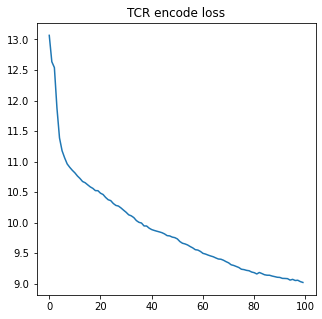

In [358]:
# training the autoencoder to encode the TCR sequence
def train_autoencoder(model, train_loader, optimizer, criterion, epoch, seq_length):
    model.train()
    batch_loss = 0
    # model_accuracy = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.float()
        data = data.view(batch_size, 5, seq_length)
        optimizer.zero_grad()
        _, output = model(data)
        # print(output.shape, data.shape)
        loss = criterion(output, data)
        # TCR_encode_losses.append(loss.item() / model.batch_size)
        # TCR_encode_losses.append(loss.item())
        # sum up batch loss
        batch_loss += loss.item()
        # update the accuracy of the model
        # pred = output.data.max(1, keepdim=True)[1]
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            # print(f"The accuracy of the model is ")
            
    # return batch_loss / len(train_loader.dataset)
    return batch_loss / len(data)

# parameters setting
epochs = 100
batch_size = 16
learning_rate = 1e-3
kernel_size = 3
stride = 2
padding = 1
seq_length = int(TCRData[0][0].shape[0] / 5)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# train the autoencoder
model = TCR_autoencoder(kernel_size=kernel_size, stride=stride, padding=padding, batch_size=batch_size)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
criterion = nn.MSELoss()
train_loader = DataLoader(TCRData, batch_size=batch_size, shuffle=True, drop_last=True)

# plot the loss
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

TCR_encode_losses = []
TCR_accuracy = 0
for epoch in range(1, epochs + 1):
    TCR_encode_loss = train_autoencoder(model, train_loader, optimizer, criterion, epoch, seq_length)
    TCR_encode_losses.append(TCR_encode_loss)
ax.set_title("TCR encode loss")
ax.plot(TCR_encode_losses, label="TCR encode loss")

In [359]:
epochs = 100
batch_size = 16
learning_rate = 1e-3
kernel_size = 3
stride = 2
padding = 1

# load the model
# model = TCR_autoencoder(kernel_size=kernel_size, stride=stride, padding=padding, batch_size=batch_size)
# model.load_state_dict(torch.load("/DATA/User/wuxinchao/project/pMHC-TCR/ckpt/TCR_autoencoder.pt"))

model.eval()

# encode the TCR sequence
file_path = "~/data/project/data/seqData/20230228.csv"
TCRData = TCR_encode_data(file_path)
# TCR_loader = DataLoader(TCRData, batch_size=batch_size, shuffle=True, drop_last=True)
TCR_encode = torch.zeros((0, 20, 1))
for i in range(len(TCRData)):
    TCR_seq = TCRData[i][0]
    TCR_seq = TCR_seq.view(1, 5, 49).float()
    encoded, _ = model(TCR_seq)
    TCR_encode = torch.cat((TCR_encode, encoded), dim=0)

{'AseqCDR3': 25, 'BseqCDR3': 24}
(2492, 6)


In [56]:
# for test, not used
model = TCR_autoencoder(kernel_size=kernel_size, stride=stride, padding=padding, batch_size=batch_size)
kernel_size, stride, padding, seq_length
# pool of size=3, stride=2
# m = nn.MaxPool1d(3, stride=1)
# m = nn.Conv1d(16, 33, 3, stride=2, padding=1)
m = nn.ConvTranspose1d(16, 8, kernel_size=3, stride=2, padding=1)
# m = nn.MaxUnpool1d(kernel_size=3, stride=1)
input = torch.randn(20, 16, 3)
output = m(input)
output.shape
# TCRData[0][0].shape
len(TCRData)
# model(TCRData[0:3][0].float().view(3,5,seq_length))

In [66]:
class LSTM_TCR_encode(nn.Module):
    '''
    LSTM for TCR sequence encoding.
    The input size of LSTM is (batch_size, seq_length, input_size), the output size is (batch_size, seq_length, hidden_size)
    '''
    def __init__(self, seq_length, hidden_size, num_layers, device):
        super(LSTM_TCR_encode, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.device = device
        self.lstm = nn.LSTM(seq_length, hidden_size, num_layers, batch_first=True, bidirectional=True)

    def forward(self, x):
        x = x.float()
        # Set initial hidden and cell states
        h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(self.device)
        c0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(self.device)
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))
        return out

In [9]:
# Train the LSTM model for TCR sequence encoding, this may not be used in the future
# How to use the LSTM model to encode the TCR sequence
# The optimization 
def train_LSTM_TCR_encode(model, train_loader, optimizer, criterion, epoch, seq_length):
    model.train()
    batch_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.float()
        data = data.view(batch_size, seq_length, 5)
        optimizer.zero_grad()
        output = model(data)
        # print(output.shape, data.shape)
        loss = criterion(output, data)
        batch_loss += loss.item()
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print(f"Training: {batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%) \
                  Loss: {loss.item():.6f}")
    return batch_loss / len(train_loader.dataset)

# parameters setting
epochs = 100
batch_size = 16
learning_rate = 1e-3
hidden_size = 16
num_layers = 2
seq_length = int(TCRData[0][0].shape[0] / 5)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# train the LSTM model
model = LSTM_TCR_encode(seq_length, hidden_size, num_layers, device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
criterion = nn.MSELoss()

In [360]:
class pMHC_TCRDataset(Dataset):
    '''
    The dataset for the encoded features of TCR sequence, and the Atchley factor of neoantigen sequence, and the HLA one-hot encoding.
    Here the input is the TCR sequence, neoantigen sequence, and HLA type.
    The output should be the encoded features of TCR sequence, and the Atchley factor of neoantigen sequence, and the HLA one-hot encoding.
    '''
    def __init__(self, 
                 file_path, 
                 only_CDR3: bool = False, 
                 only_experimental: bool = False, 
                 TCR_encode: str = ["LSTM", "CNN"],
                 encoding_model: nn.Module = None,
                 encoding_size = 20) -> None:
        df, HLA_encode, y  = self.basic_io(file_path, only_experimental=only_experimental)

        # convert from object to tensor
        X_TCR_seq = torch.zeros((len(df), 0))
        for region in ["AseqCDR3", "BseqCDR3"]:
            TCR_seq = df.loc[:, region].values
            TCR_seq_encode = torch.zeros((0, TCR_seq[0].shape[1]))
            for i in range(len(TCR_seq)):
                encoding = torch.from_numpy(TCR_seq[i][0])
                encoding = encoding.reshape(1, -1)
                TCR_seq_encode = torch.cat((TCR_seq_encode, encoding), dim=0)

            X_TCR_seq = torch.cat((TCR_seq_encode, X_TCR_seq), dim=1)
        
        if TCR_encode == "CNN":
            X_TCR_seq = X_TCR_seq.view(-1, 5, 49)
        elif TCR_encode == "LSTM":
            X_TCR_seq = X_TCR_seq.view(-1, 5, 49)
        else:
            raise ValueError("The TCR encoding method is not supported yet.")
        
        # encoding model 
        X_features, _ = encoding_model(X_TCR_seq)
        X_features = X_features.view(-1, encoding_size).data

        # add the neoantigen sequence encoding features
        for seq in ["Neo_first3", "Neo_last3"]:
            neo = df.loc[:, seq].values
            neo_encode = torch.zeros((0, neo[0].shape[1]))
            for i in range(len(neo)):
                encoding = torch.from_numpy(neo[i][0])
                encoding = encoding.reshape(1, -1)
                neo_encode = torch.cat((neo_encode, encoding), dim=0)
            X_features = torch.cat((X_features, neo_encode), dim=1)

        X_features = torch.cat((X_features, torch.from_numpy(HLA_encode)), dim=1)

        self.X_features = X_features
        self.y = torch.from_numpy(y)
            
    
    def basic_io(self, file_path, only_experimental=True):
        # return the dataframe, contain the 
        df = pd.read_csv(file_path, index_col=0)
        df = df.loc[df["AseqCDR3"].str.len() < 50, :]
        # for chain in ["AseqCDR", "BseqCDR"]:
        #     if only_CDR3:
        #         df[chain+"_3"] = df[chain].str.split("_").str[2]
        #         df.drop(columns=[chain], inplace=True)
        #     else:
        #         df[chain+"_1"] = df[chain].str.split("_").str[0]
        #         df[chain+"_2"] = df[chain].str.split("_").str[1]
        #         df[chain+"_3"] = df[chain].str.split("_").str[2]
        #         df.drop(columns=[chain], inplace=True)
        df["Neo_first3"] = df["NeoAA"].str[:3]
        df["Neo_last3"] = df["NeoAA"].str[-3:]
        df = df.drop(columns=["NeoAA"])

        # encode the Neo_first3, Neo_last3
        for seq in ["Neo_first3", "Neo_last3"]:
            df[seq] = df[seq].apply(lambda x: encode_seqCDR(x))

        # encode the CDR3 region
        len_map = {
            "AseqCDR3": df["AseqCDR3"].apply(lambda x: len(x)).max(),
            "BseqCDR3": df["BseqCDR3"].apply(lambda x: len(x)).max(),
        }
        for chain in ["AseqCDR3", "BseqCDR3"]:
            length = len_map[chain]
            df[chain] = df[chain].apply(lambda x: x + "*" * (length - len(x)))
            df[chain] = df[chain].apply(lambda x: encode_seqCDR(x))
        
        # drop the rows with nan
        df = df.dropna()

        if not only_experimental:
            df_ps = df[df["Class"] == "positive"]
            df_ng_ex = df[df["Class"] == "negative"]
            df_ng_em = df.copy()
            df_ng_em = df_ng_em[df_ng_em["Class"] == "positive"]
            df_ng_em["AseqCDR_3"] = df_ng_em["AseqCDR_3"].apply(
                lambda x: random.choice(list(set(df_ng_em["AseqCDR_3"]) - set(x))))
            df_ng_em["BseqCDR_3"] = df_ng_em["BseqCDR_3"].apply(
                lambda x: random.choice(list(set(df_ng_em["BseqCDR_3"]) - set(x))))
            df_ng = pd.concat([df_ng_em, df_ng_ex], axis=0)
            df_ng.index = range(len(df_ng))
            df = pd.concat([df_ps, df_ng], axis=0)

        X_HLA = df["HLA"].values.reshape(-1, 1)
        HLAencoder = OneHotEncoder()
        X_HLA_encoded = HLAencoder.fit_transform(X_HLA).toarray()
        
        y = df["Class"].apply(lambda x: 1 if x == "positive" else 0)
        y.value_counts().plot.pie(autopct='%.2f')
        return df, X_HLA_encoded, y.values

    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X_features[idx], self.y[idx]

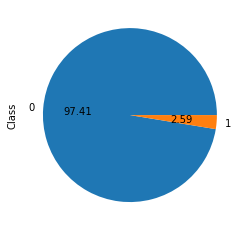

In [361]:
TCRData = pMHC_TCRDataset(file_path, TCR_encode="CNN", only_experimental=True, encoding_model=model)

In [365]:
# TCRData[0][0].shape
97.41 / 2.59

37.61003861003861

In [48]:
# for test
df = pd.read_csv(file_path, index_col=0)
df = df.loc[df["AseqCDR3"].str.len() < 50, :]

df["Neo_first3"] = df["NeoAA"].str[:3]
df["Neo_last3"] = df["NeoAA"].str[-3:]
df = df.drop(columns=["NeoAA"])

# encode the Neo_first3, Neo_last3
for seq in ["Neo_first3", "Neo_last3"]:
    df[seq] = df[seq].apply(lambda x: encode_seqCDR(x))

# encode the CDR3 region
len_map = {
    "AseqCDR3": df["AseqCDR3"].apply(lambda x: len(x)).max(),
    "BseqCDR3": df["BseqCDR3"].apply(lambda x: len(x)).max(),
}
for chain in ["AseqCDR3", "BseqCDR3"]:
    length = len_map[chain]
    df[chain] = df[chain].apply(lambda x: x + "*" * (length - len(x)))
    df[chain] = df[chain].apply(lambda x: encode_seqCDR(x))

# drop the rows with nan
df = df.dropna()

X_HLA = df["HLA"].values.reshape(-1, 1)
HLAencoder = OneHotEncoder()
X_HLA_encoded = HLAencoder.fit_transform(X_HLA).toarray()

y = df["Class"].apply(lambda x: 1 if x == "positive" else 0).values

In [363]:
class prediction_model(nn.Module):
    def __init__(self, 
                 input_size,
                 batch_size=32,) -> None:
        super(prediction_model, self).__init__()
        self.input_size = input_size
        self.batch_size = batch_size
        self.linear_layer = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 2),
        )
        self.softmax = nn.Softmax(dim=1)

    def forward(self, input):
        input = input.view(self.batch_size, self.input_size)
        # print(f"The model input shape is : {input.shape}")
        output = self.linear_layer(input)
        output = self.softmax(output)
        return output

In [371]:
def train(fold, model, device, train_loader, optimizer, epoch, criterion):
    model.train()
    train_loss = 0
    correct = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        # one-hot encoding the target
        target = target.to(torch.float32).view(-1, 1)
        target = target.to(torch.bool)
        one_hot_target = torch.zeros((target.shape[0], 2))
        one_hot_target[(target==1).squeeze(), 1] = 1
        one_hot_target[(target==0).squeeze(), 0] = 1

        data, one_hot_target = data.to(device), one_hot_target.to(device)
        # data.data extract the item of the torch without the hook on the computation graph
        data = data.view(-1, 20+5*6+2).to(torch.float32)
        output = model(data) # output shape: (batch_size, 2)
        # based on the one-hot target to decide the weights of loss for each class
        # weight = (one_hot_target == torch.tensor([0, 1]).to(device)).sum() / (one_hot_target == torch.tensor([1, 0]).to(device)).sum()
        # weights = torch.tensor([1, 1/weight]).to(device)
        # loss = nn.CrossEntropyLoss(weight=weights)(output, one_hot_target.data)
        loss = criterion(output, one_hot_target.data)
        train_loss += loss.item() * batch_size
        # The loss has been weighted, and the loss has already been divided by the batch size
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # get the prediction
        pred = output.argmax(dim=1, keepdim=True) # shape: (batch_size, 1)
        correct += pred.eq(one_hot_target.argmax(dim=1, keepdim=True)).sum().item()

        if batch_idx % 100 == 0:
            print(f"Training stage for Flod {fold} Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} \
                ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")
            # print(f"The current output is {output}, and the target is {one_hot_target}")
            # print(f"The weight of the batch is {weights}, \n The output is {output}, \n The one_hot_target is {one_hot_target.data}")
    return train_loss, correct / len(train_loader.dataset)


def test(fold, model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            # one-hot encoding the target
            target = target.to(torch.float32).view(-1, 1)
            target = target.to(torch.bool)
            one_hot_target = torch.zeros((target.shape[0], 2))
            one_hot_target[(target==1).squeeze(), 1] = 1
            one_hot_target[(target==0).squeeze(), 0] = 1

            data, one_hot_target = data.to(device), one_hot_target.to(device)
            data = data.view(-1, 20+5*6+2).to(torch.float32).data
            output = model(data) # output shape: (batch_size, 2)
            # get the test loss and prediction
            test_loss += nn.CrossEntropyLoss()(output, one_hot_target.data).item() * len(test_loader.dataset)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(one_hot_target.argmax(dim=1, keepdim=True)).sum().item()
    
    # test_loss /= len(test_loader.dataset)
    print(f"Test set for fold{fold}: Average Loss: \
          {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} \
          ({100. * correct / len(test_loader.dataset):.0f}%)")
    # print(f"The length of test_loader is {len(test_loader)}")
    return test_loss, correct / len(test_loader.dataset)

In [372]:
# Parameters
batch_size = 32
input_size = 52
folds = 5
epochs = 100
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using {device} for training")

def reset_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        m.reset_parameters()

model = prediction_model(input_size=input_size, batch_size=batch_size).to(device)
kf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=42)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss().to(device)

Using cuda:0 for training


-------------------Fold 0-------------------
Training stage for Flod 0 Epoch: 1 [0/29980                 (0%)]	Loss: 0.706105
Training stage for Flod 0 Epoch: 1 [3200/29980                 (11%)]	Loss: 0.477374
Training stage for Flod 0 Epoch: 1 [6400/29980                 (21%)]	Loss: 0.456921
Training stage for Flod 0 Epoch: 1 [9600/29980                 (32%)]	Loss: 0.376935
Training stage for Flod 0 Epoch: 1 [12800/29980                 (43%)]	Loss: 0.403605
Training stage for Flod 0 Epoch: 1 [16000/29980                 (53%)]	Loss: 0.727357
Training stage for Flod 0 Epoch: 1 [19200/29980                 (64%)]	Loss: 0.530165
Training stage for Flod 0 Epoch: 1 [22400/29980                 (75%)]	Loss: 0.498785
Training stage for Flod 0 Epoch: 1 [25600/29980                 (85%)]	Loss: 0.348809
Training stage for Flod 0 Epoch: 1 [28800/29980                 (96%)]	Loss: 0.396906
Test set for fold0: Average Loss:           812818.0365, Accuracy: 6340/7496           (85%)
Training s

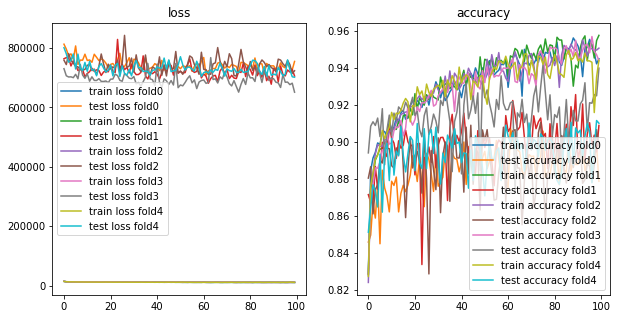

In [373]:
fig, ax = plt.subplots(1,2, figsize=(10, 5))
ax[0].set_title("loss")
ax[1].set_title("accuracy")

for fold, (train_idx, test_idx) in enumerate(kf.split(TCRData.X_features, TCRData.y)):
    print(f"-------------------Fold {fold}-------------------")
    # Randomly select the train and test samples to generate train and test datasets
    train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
    test_sampler = torch.utils.data.SubsetRandomSampler(test_idx)
    train_dataset = torch.utils.data.Subset(TCRData, train_idx)
    test_dataset = torch.utils.data.Subset(TCRData, test_idx)
    
    # weighted random sampler for train and test datasets
    y_train = [TCRData.y[i] for i in train_idx]
    class_sample_count = np.array([len(np.where(y_train == t)[0]) for t in np.unique(y_train)])
    weights = 1. / class_sample_count
    samples_weight = torch.from_numpy(np.array([weights[t] for t in y_train]))
    train_sampler = WeightedRandomSampler(samples_weight.type('torch.DoubleTensor'), len(samples_weight))
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, drop_last=True)
    
    y_test = [TCRData.y[i] for i in test_idx]
    class_sample_count = np.array([len(np.where(y_test == t)[0]) for t in np.unique(y_test)])
    weights = 1. / class_sample_count
    samples_weight = torch.from_numpy(np.array([weights[t] for t in y_test]))
    test_sampler = WeightedRandomSampler(samples_weight.type('torch.DoubleTensor'), len(samples_weight))
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, sampler=test_sampler, drop_last=True)

    model.apply(reset_weights)
    train_losses_history = []
    test_losses_history = []
    train_accuracy_history = []
    test_accuracy_history = []

    for epoch in range(1, epochs+1):
        train_losses, train_correct = train(fold, model, device, train_dataloader, optimizer, epoch, criterion)
        test_losses, test_correct = test(fold, model, device, test_dataloader)
        train_losses_history.append(train_losses)
        test_losses_history.append(test_losses)
        train_accuracy_history.append(train_correct)
        test_accuracy_history.append(test_correct)
    ax[0].plot(train_losses_history, label=f"train loss fold{fold}")
    ax[0].plot(test_losses_history, label=f"test loss fold{fold}")
    ax[1].plot(train_accuracy_history, label=f"train accuracy fold{fold}")
    ax[1].plot(test_accuracy_history, label=f"test accuracy fold{fold}")
ax[0].legend()
ax[1].legend()

Using cuda:0 for training
-------------------Fold 0-------------------
Training stage for Flod 0 Epoch: 1 [0/37476                 (0%)]	Loss: 0.934957
The weight of the batch is tensor([1., inf], device='cuda:0'), 
 The output is tensor([[0.3114, 0.6886],
        [0.3008, 0.6992],
        [0.2090, 0.7910],
        [0.3380, 0.6620],
        [0.2680, 0.7320],
        [0.2953, 0.7047],
        [0.2819, 0.7181],
        [0.2746, 0.7254],
        [0.2777, 0.7223],
        [0.2991, 0.7009],
        [0.3069, 0.6931],
        [0.2814, 0.7186],
        [0.2875, 0.7125],
        [0.2563, 0.7437],
        [0.2455, 0.7545],
        [0.2621, 0.7379],
        [0.2777, 0.7223],
        [0.2705, 0.7295],
        [0.2712, 0.7288],
        [0.2896, 0.7104],
        [0.2732, 0.7268],
        [0.2787, 0.7213],
        [0.3176, 0.6824],
        [0.2810, 0.7190],
        [0.2971, 0.7029],
        [0.2939, 0.7061],
        [0.3021, 0.6979],
        [0.2684, 0.7316],
        [0.2719, 0.7281],
        [0.2595

KeyboardInterrupt: 

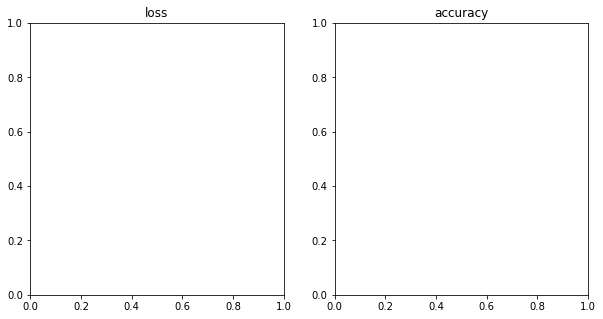

In [346]:
# test
for fold, (train_idx, test_idx) in enumerate(kf.split(TCRData.X_features, TCRData.y)):
    print(f"-------------------Fold {fold}-------------------")
    # undersample the training data
    # X_res, y_res = rus.fit_resample(TCRData)
    if batch_size == 1:
    # using the subsampler to get the data
        train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)
        test_subsampler = torch.utils.data.SubsetRandomSampler(test_idx)
        train_dataset = torch.utils.data.Subset(TCRData, train_idx)
        test_dataset = torch.utils.data.Subset(TCRData, test_idx)
        train_loader = torch.utils.data.DataLoader(TCRData, batch_size=len(train_dataset), sampler=train_subsampler)
        test_loader = torch.utils.data.DataLoader(TCRData, batch_size=len(test_dataset), sampler=test_subsampler)
    else:
        y_train = [TCRData.y[i] for i in train_idx]
        class_sample_count = np.array([len(np.where(y_train == t)[0]) for t in np.unique(y_train)])
        weights = 1. / class_sample_count
        samples_weight = np.array([weights[t] for t in y_train])
        samples_weight = torch.from_numpy(samples_weight)
        sampler = WeightedRandomSampler(samples_weight.type('torch.DoubleTensor'), len(samples_weight))
        train_dataloader = DataLoader(TCRData, batch_size=batch_size, sampler=sampler, drop_last=True)

        # train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)
        # test_subsampler = torch.utils.data.SubsetRandomSampler(test_idx)
        # train_loader = torch.utils.data.DataLoader(TCRData, 
        #     batch_size=batch_size, sampler=train_subsampler, drop_last=True)
        # test_loader = torch.utils.data.DataLoader(TCRData, 
        #     batch_size=batch_size, sampler=test_subsampler, drop_last=True)
        
    model.apply(reset_weights)
    train_losses_history = []
    test_losses_history = []
    train_accuracy_history = []
    test_accuracy_history = []

    for epoch in range(1, epochs+1):
        train_losses, train_correct = train(fold, model, device, train_loader, optimizer, epoch, criterion)
        test_losses, test_correct = test(fold, model, device, test_loader)
        train_losses_history.append(train_losses)
        test_losses_history.append(test_losses)
        train_accuracy_history.append(train_correct)
        test_accuracy_history.append(test_correct)
    # ax[0].plot(train_losses_history, "r*--" ,label=f"train loss fold{fold}")
    # ax[0].plot(test_losses_history, "bs--", label=f"test loss fold{fold}")
    # ax[1].plot(train_accuracy_history, "g^--", label=f"train accuracy fold{fold}")
    # ax[1].plot(test_accuracy_history, "yo--", label=f"test accuracy fold{fold}")
    ax[0].plot(train_losses_history, label=f"train loss fold{fold}")
    ax[0].plot(test_losses_history, label=f"test loss fold{fold}")
    ax[1].plot(train_accuracy_history, label=f"train accuracy fold{fold}")
    ax[1].plot(test_accuracy_history, label=f"test accuracy fold{fold}")
    break
ax[0].legend()
ax[1].legend()
# put the legend out of the figure, and adjust the position, prevent the figure from being covered
# ax[0].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# ax[1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# save the figure
# fig.savefig("/DATA/User/wuxinchao/project/pMHC-TCR/result/pMHC_without_em_with_encoder_loss_accuracy.png")

In [ ]:
c = torch.randn((32, 92)).to(device)
# # a.shape
d = model(c).to(device)
model.train()
optimizer.zero_grad()
# loss = nn.CrossEntropyLoss()(model(a).to(torch.float32).view(32, 1, 1), torch.ones((32, 1, 1)).to(torch.float32).to(device)) / 32
# loss.to(device)
# loss.backward()
# optimizer.step()
loss_fn = nn.CrossEntropyLoss()
a = torch.randint(0,2,(32,1)) # mask
b = torch.zeros((32,2))
# get the value of b where a is 1
a = a.to(torch.bool)
b[(a==1).squeeze(),1] = 1
b[(a==0).squeeze(),0] = 1

In [342]:
# loss = loss_fn(d, torch.ones((32,2)).to(device))
# loss.backward()
# train_losses_history
# test_losses_history
# test_accuracy_history
# train_accuracy_history
# nn.Softmax(dim=1)(torch.tensor([[1,2,3],[4,5,6]], dtype=torch.float32))
# output = nn.Softmax(dim=1)(torch.tensor([[0.1, 0.9], [0.1, 0.9], [0.1, 0.9]], dtype=torch.float32))
# nn.CrossEntropyLoss()(output, torch.tensor([[0.0, 1.0], [0.0, 1.0], [0.0, 1.0]]))
# (b == torch.tensor([1,0])).sum() / (b == torch.tensor([0,1])).sum()
# b
# 17 / 15

# a = torch.tensor([[1,2,3,4,5],[3,3,4,5,6]], dtype=torch.float32) # print(a.shape) shape: 2, 5
# a.argmax(dim=1, keepdim=True).shape # shape: 2, 1
# a.argmax(dim=1) # shape: 1, 2

TCRData.y.sum() / len(TCRData.y)

tensor(0.0259)

In [313]:
# loss.backward()
# torch.zeros((32,2))
# model(torch.randn((32,92)).to(device))
num_dict = {1:2, 2:3, 3:0}
# delete the non-zero key
num_dict.pop(1)
num_dict.pop(2)
# print(num_dict.keys())
# get the key
print(list(num_dict.keys())[0])

3


After encoding, the features are concatanated and used to predict the binding affinity of pMHC-TCR model.

In [19]:
class pMHC_TCR_pred(nn.Module):
    def __init__(self, input_size, hidden_size, batch_size, num_layers, device, use_whole_data=False):
        super(pMHC_TCR_pred, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.batch_size = batch_size
        self.num_layers = num_layers
        self.device = device
        self.use_whole_data = use_whole_data

        # use the encoded features to predict the binding affinity through MLP
        self.Linear_layer = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1),
        )

    def forward(self, x):
        x = self.Linear_layer(x)
        return x

In [70]:
class LSTM_encode(nn.Module):
    def __init__(self, input_size, seq_length, hidden_size, batch_size, num_layers, device, use_whole_data=False):
        self.input_size = input_size
        self.seq_length = seq_length
        self.hidden_size = hidden_size
        self.batch_size = batch_size
        self.num_layers = num_layers
        self.device = device
        self.use_whole_data = use_whole_data

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)

    def forward(self, x):
        x = x.view(self.batch_size, self.seq_length, self.input_size)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(self.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(self.device)
        out, (hn, cn) = self.lstm(x, (h0, c0))
        return out[:, -1, :] # return the last hidden state

In [38]:
df = pd.read_csv(file_path, index_col=0)
df["Neo_first3"] = df["NeoAA"].str[:3]
df["Neo_last3"] = df["NeoAA"].str[-3:]
df = df.drop(columns=["NeoAA"])

# encode the Neo_first3, Neo_last3
for seq in ["Neo_first3", "Neo_last3"]:
    df[seq] = df[seq].apply(lambda x: encode_seqCDR(x))

# encode the CDR3 region
df = df.drop_duplicates(subset=["AseqCDR3", "BseqCDR3"], keep="first")

len_map = {
    "AseqCDR3": df["AseqCDR3"].apply(lambda x: len(x)).max(),
    "BseqCDR3": df["BseqCDR3"].apply(lambda x: len(x)).max(),
}
print(len_map)
# drop the rows with length == max length, which is much longer than the others
df = df.loc[df["AseqCDR3"].str.len() < len_map["AseqCDR3"], :]

{'AseqCDR3': 82, 'BseqCDR3': 24}


(array([3.200e+02, 2.288e+03, 2.800e+01, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 1.000e+00, 1.100e+01]),
 array([ 5. , 12.6, 20.2, 27.8, 35.4, 43. , 50.6, 58.2, 65.8, 73.4, 81. ]),
 <BarContainer object of 10 artists>)

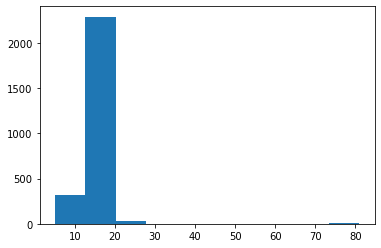

In [43]:
# df["AseqCDR3"].value_counts()
# df["AseqCDR3"].str.len().sort_values(axis=0) # find the longest seq
# df.loc[df["AseqCDR3"].str.len() == 83, "AseqCDR3"]

plt.hist(df["AseqCDR3"].str.len().sort_values(axis=0))
# plt.show()
# df = df.loc[df["AseqCDR3"].str.len() < 83, :]
# df["AseqCDR3"].str.len().sort_values(axis=0)

In [100]:
# len_map
df.to_csv("/home/wuxinchao/data/project/data/seqData/20230228.csv")
# df.loc[df["AseqCDR3"].str.contains("_"),]
# df.shape